### Test edge moves

In [117]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

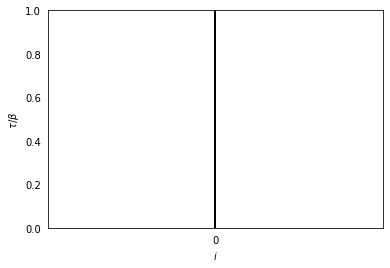

In [118]:
importlib.reload(pimc)
# Simulation parameters
t = 0
U = 1
mu = 10
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity

# Canonical or Grand Canonical?
canonical = False

# Create a worldline configuration
L = 1
N = 2
alpha = []
for i in range(L):
    alpha.append(N)
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

# Choose the type of worm 

### Apply the same type of edge insert move many times

In [ ]:
importlib.reload(pimc)
# Do insert many times on the above configuration
mc_steps = int(1E+05)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
 
for m in range(mc_steps):

    pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,
                            canonical,N)
 
    if head_loc != [] and tail_loc == []: # Only head present
        tau = data_struct[head_loc[0]][head_loc[1]][0]
        
    elif head_loc == [] and tail_loc != []: # Only tail present
        tau = data_struct[tail_loc[0]][tail_loc[1]][0]

    else: # No worm ends
        continue
    
    worm_lengths[m] = beta - tau
    if worm_lengths[m] < 0: # antiworm correction
        worm_length += beta
    
    if m == mc_steps - 1: break
        
    # Create a worldline configuration
    alpha = []
    for i in range(L):
        alpha.append(N)
    data_struct = pimc.create_data_struct(alpha)
    head_loc = []
    tail_loc = []

pimc.view_worldlines(data_struct,beta,figure_name=None)

In [115]:
# Histogram of worm lengths
b = beta
loc = 0

# Calculate change in diagonal energy
if head_loc != [] and tail_loc == []: # Only head present
    tau = data_struct[head_loc[0]][head_loc[1]][0]
    n_o = data_struct[head_loc[0]][head_loc[1]][1]
    n_f = n_o + 1

elif head_loc == [] and tail_loc != []: # Only tail present
    tau = data_struct[tail_loc[0]][tail_loc[1]][0]
    n_f = data_struct[tail_loc[0]][tail_loc[1]][1]
    n_o = n_f - 1
    
# Calculate change in diagonal energy after/before worm end (need this for scale)
dV = (U/2)*(n_f*(n_f-1)-n_o*(n_o-1)) - mu*(n_f-n_o)

if dV == 0:
    dV = np.finfo(float).eps # machine epsilon
scale = 1/abs(dV)

# Generate truncated exponential distribution of worm lengths
tau_w = np.linspace(0,beta,int(1E+02+1))                    # worm lengths
tau_w = (tau_w[1:]+tau_w[0:-1])/2    
#[time,N,(src,dest)]

# Theoretical distribution of lenghths (worm and antiworm)
pdf = truncexpon.pdf(tau_w,b=b/scale,loc=loc,scale=scale)
# Rescale & normalize the truncated exponential pdf
# if tau_t < tau_h:
#     pdf *= (beta-tau_w)     # worm
# else:
#     pdf *= (tau_w)           # antiworm?
pdf /= simps(pdf,tau_w)

# Sampled worm lengths
n, bins = np.histogram(worm_lengths, bins=tau_w, density=1) # for histogram

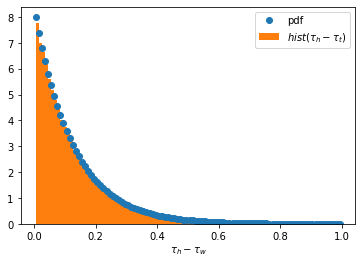

In [116]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(tau_w,pdf,label='pdf',linestyle='None',marker='o')
ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=1,label=r'$hist(\tau_h-\tau_t)$')
ax.set_xlabel(r"$\tau_h - \tau_w$") ;
#ax.set_yscale("log");
plt.legend() ;
plt.savefig("insertBeta_%d_%d_%.4f_%.4f_%.4f_%.4f_%d_anti.pdf"%(L,N,U,mu,t,eta,mc_steps))